In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
link = "https://raw.githubusercontent.com/yagmurtomruk/yagmurtomruk/main/DSA210_DATA.xlsx"
df = pd.read_excel(link)

# Dealing with the dates:
df['Date'] = pd.to_datetime(df['Date'])


Initially, the missing values should be handled correctly.
During my data collection period, there has been some days where I had to take rest days due to sickness or schedule, and some days where the data was not succesfully obtained from the smartwatch. So, these missing values had to be detected and filled with the mean value for correction:

In [ ]:
# Cleaning the data:
# Fill missing values with the mean
print("Missing values:")
print(df.isnull().sum())
df.fillna(df.mean(), inplace=True)


Missing values:
Date                     0
Temperature              0
Humidity                 0
AQI                      0
PM2.5 conc.              0
NO2 conc                 0
Running Distance (km)    3
Pace (min/km)            4
Heart Rate (BPM)         4
dtype: int64


# **VISUALIZATION:**

In [ ]:
# Categorizing the AQI values:

def categorize_aqi(aqi):
    if aqi <= 50:
        return "Good"
    elif aqi <= 100:
        return "Moderate"
    elif aqi <= 150:
        return "Unhealthy for Sensitive Groups"
    else:
        return "Unhealthy"

df["AQI_Category"] = df["AQI"].apply(categorize_aqi)

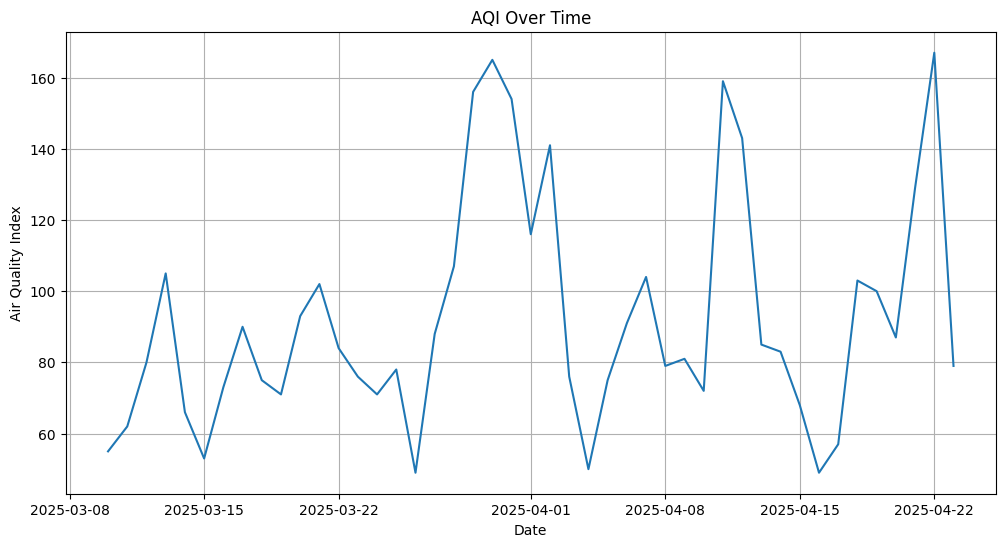

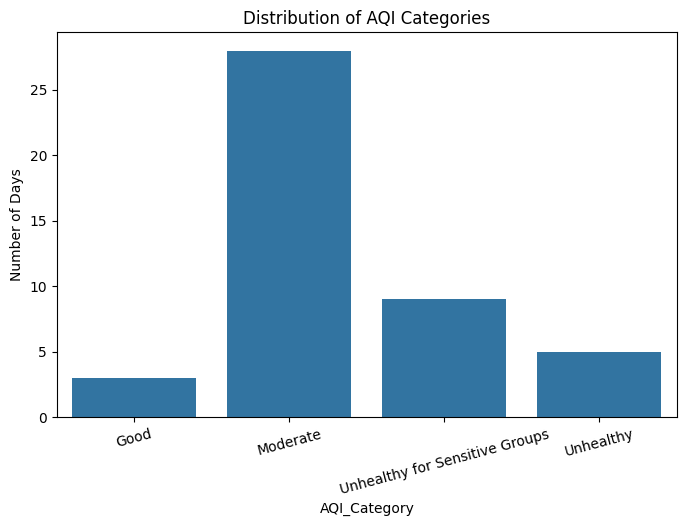

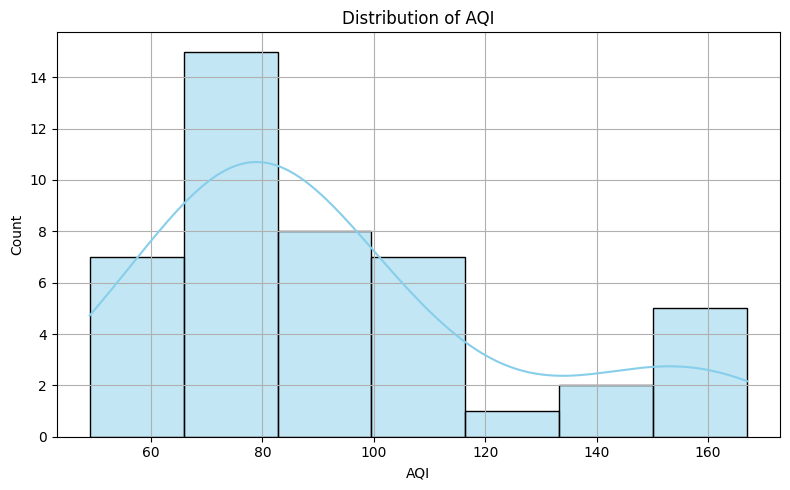

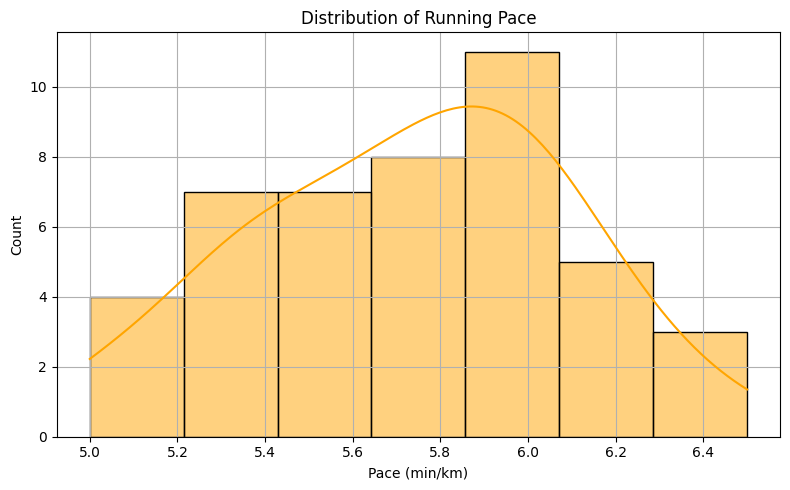

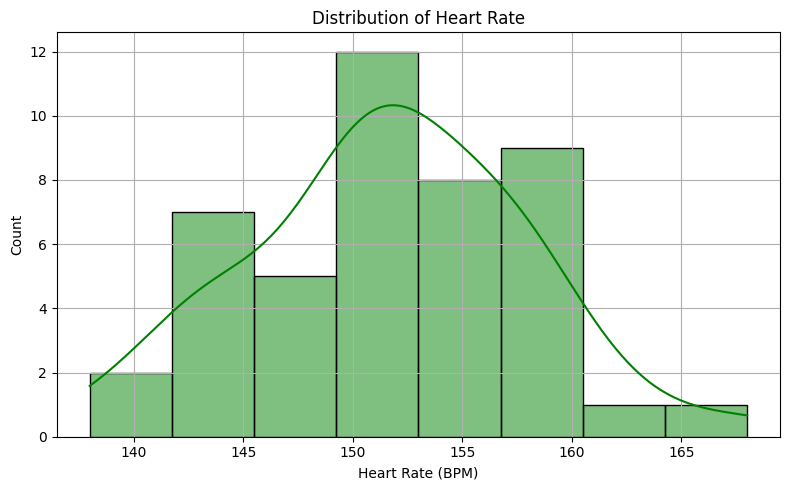

In [ ]:
# Visualizations
# How AQI changes over time:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="Date", y="AQI")
plt.title("AQI Over Time")
plt.xlabel("Date")
plt.ylabel("Air Quality Index")
plt.grid(True)
plt.show()

# AQI categories by date:
plt.figure(figsize=(8, 5))
sns.countplot(x="AQI_Category", data=df, order=["Good", "Moderate", "Unhealthy for Sensitive Groups", "Unhealthy"])
plt.title("Distribution of AQI Categories")
plt.ylabel("Number of Days")
plt.xticks(rotation=15)
plt.show()

# Distribution of some of the important attributes:


dist_plots = {"AQI": ("Distribution of AQI", "skyblue"),"Pace (min/km)": ("Distribution of Running Pace", "orange"),"Heart Rate (BPM)": ("Distribution of Heart Rate", "green")}

# Plotting the distributions:
for var, (title, color) in dist_plots.items():
    plt.figure(figsize=(8, 5))
    sns.histplot(df[var], kde=True, color=color)
    plt.title(title)
    plt.xlabel(var)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

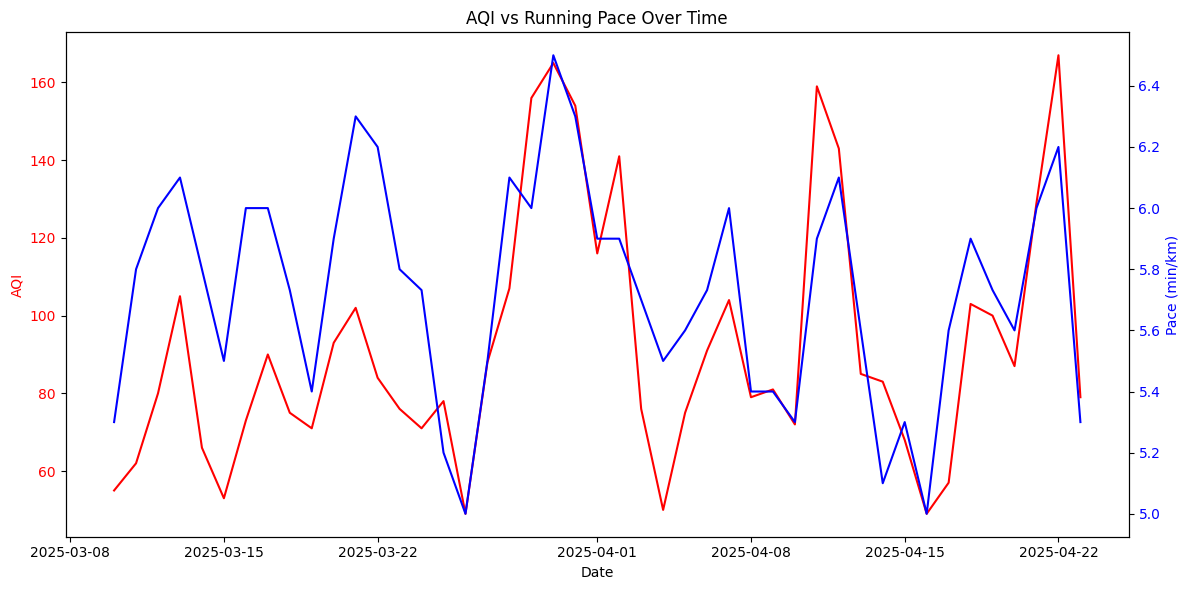

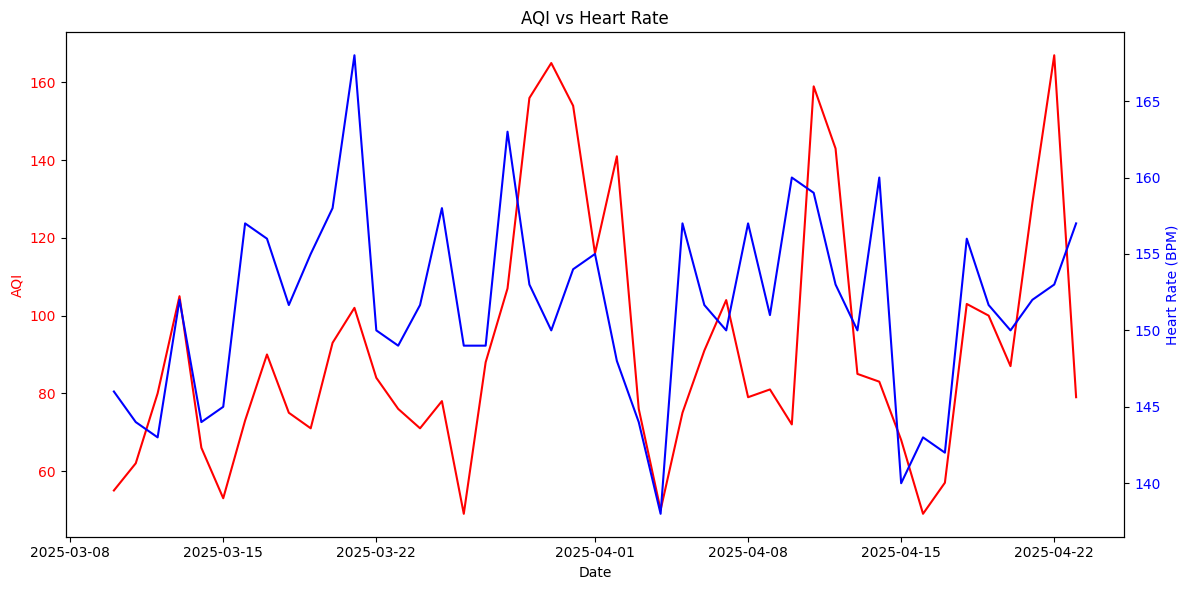

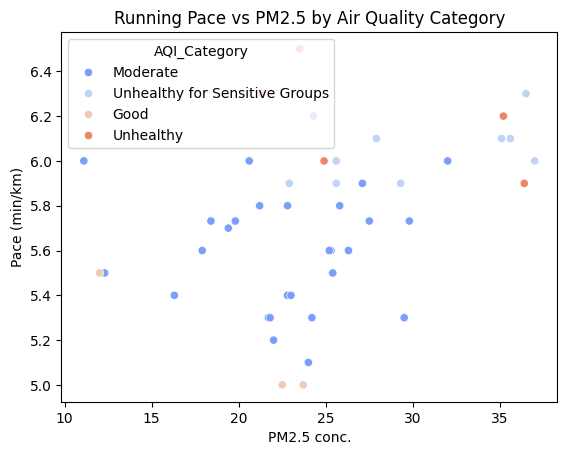

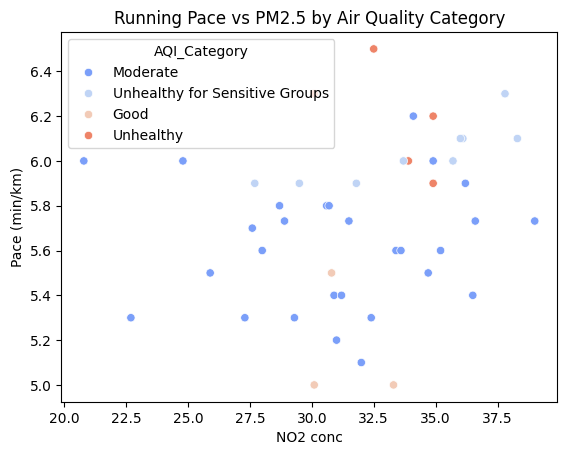

In [ ]:
# AQI vs Pace:

fig, ax1 = plt.subplots(figsize=(12,6))

ax1.set_xlabel('Date')
ax1.set_ylabel('AQI', color='red')
ax1.plot(df['Date'], df['AQI'], color='red', label='AQI')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()
ax2.set_ylabel('Pace (min/km)', color='blue')
ax2.plot(df['Date'], df['Pace (min/km)'], color='blue', label='Pace')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title('AQI vs Running Pace Over Time')
fig.tight_layout()
plt.show()

# AQI vs Heart Rate:
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.set_xlabel('Date')
ax1.set_ylabel('AQI', color='red')
ax1.plot(df['Date'], df['AQI'], color='red', label='AQI')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()
ax2.set_ylabel('Heart Rate (BPM)', color='blue')
ax2.plot(df['Date'], df['Heart Rate (BPM)'], color='blue', label='Pace')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title('AQI vs Heart Rate')
fig.tight_layout()
plt.show()

# PM2.5 vs Pace:

sns.scatterplot(data=df, x="PM2.5 conc.", y="Pace (min/km)", hue="AQI_Category", palette="coolwarm")
plt.title("Running Pace vs PM2.5 by Air Quality Category")
plt.show()

# NO2 vs Pace:

sns.scatterplot(data=df, x="NO2 conc", y="Pace (min/km)", hue="AQI_Category", palette="coolwarm")
plt.title("Running Pace vs PM2.5 by Air Quality Category")
plt.show()


## **CORRELATION ANALYSIS:**

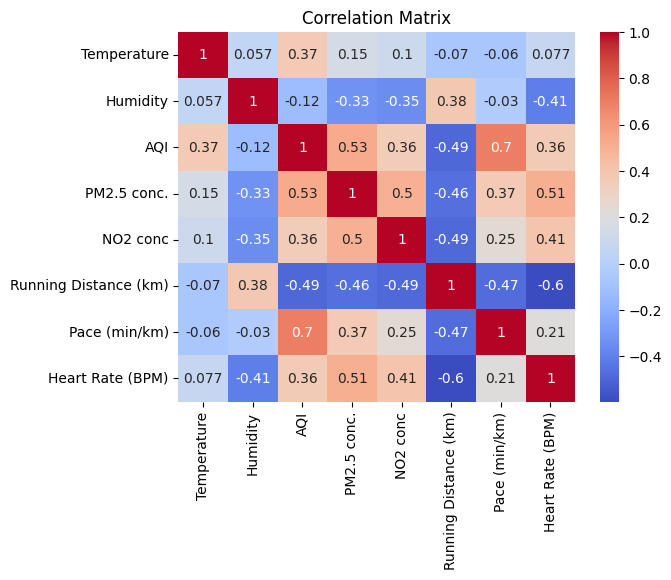

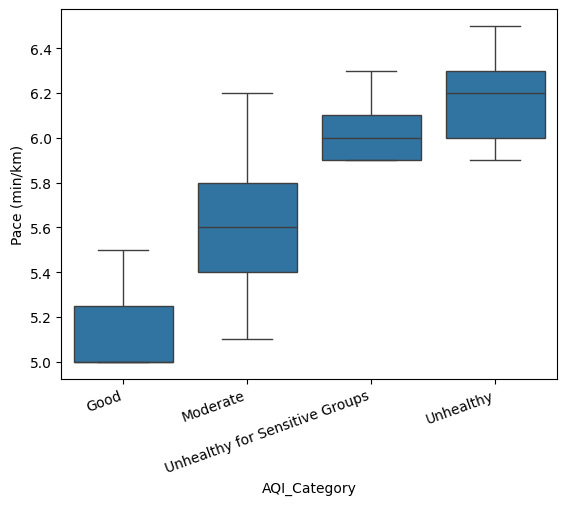

In [ ]:
# Correlation heatmap
# Selecting numeric columns for correlation
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Plot correlation heatmap
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Box plot to compare the paces for different AQI quality groups
order = ["Good", "Moderate", "Unhealthy for Sensitive Groups", "Unhealthy"]
sns.boxplot(x="AQI_Category", y="Pace (min/km)", data=df, order=order)
plt.xticks(rotation=20, ha='right');


# **HYPOTHESIS TESTING**

**Hypothesis:**
Running pace is slower on days with poor air quality (high AQI values) compared to days with good air quality.

**Null Hypothesis (H₀):**
AQI has no significant effect on my pace.

**Alternative Hypothesis (H₁):**
The mean running pace is slower on unhealthy air quality days compared to good air quality days.



In [ ]:
# ANOVA:
from scipy.stats import f_oneway
df["AQI_Category"] = df["AQI"].apply(categorize_aqi)

# Create a list of pace values grouped by AQI category
groups = [df[df["AQI_Category"] == cat]["Pace (min/km)"].dropna()
          for cat in ["Good", "Moderate", "Unhealthy for Sensitive Groups", "Unhealthy"]]

# Run one-way ANOVA
f_stat, p_value = f_oneway(*groups)

print("F-Statistic:", f_stat)
print("P-Value:", p_value)

if p_value < 0.05:
    print("Reject the null hypothesis. There is a significant difference between pace and AQI.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference between pace and AQI.")

F-Statistic: 16.826765923639844
P-Value: 2.817661563670174e-07
Reject the null hypothesis. There is a significant difference between pace and AQI.


In [ ]:
# INDEPENDENT T-TEST:
from scipy.stats import ttest_ind

# Group pace values by AQI category
pace_good = df[df["AQI_Category"] == "Good"]["Pace (min/km)"]
pace_unhealthy = df[df["AQI_Category"] == "Unhealthy"]["Pace (min/km)"]

# One-tailed t-test (check if pace on Unhealthy days > pace on Good days)
t_stat, p_value = ttest_ind(pace_unhealthy, pace_good, alternative='greater', nan_policy='omit')

print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: 5.410200575789248
P-value: 0.0008239725033671889
